6.1. Infrared (IR) spectroscopy technology is used to determine the chemical makeup of a substance. The theory of IR spectroscopy holds that unique
molecular structures absorb IR frequencies differently. In practice a spectrometer fires a series of IR frequencies into a sample material, and the device
measures the absorbance of the sample at each individual frequency. This
series of measurements creates a spectrum profile which can then be used to
determine the chemical makeup of the sample material.
A Tecator Infratec Food and Feed Analyzer instrument was used to analyze
215 samples of meat across 100 frequencies. A sample of these frequency profiles is displayed in Fig. 6.20. In addition to an IR profile, analytical chemistry
determined the percent content of water, fat, and protein for each sample.
If we can establish a predictive relationship between IR spectrum and fat
content, then food scientists could predict a sample’s fat content with IR
instead of using analytical chemistry. This would provide costs savings, since
analytical chemistry is a more expensive, time-consuming process:
- (a) Start R and use these commands to load the data:
The matrix absorp contains the 100 absorbance values for the 215 samples,
while matrix endpoints contains the percent of moisture, fat, and protein
in columns 1–3, respectively.
- (b) In this example the predictors are the measurements at the individual frequencies. Because the frequencies lie in a systematic order (850–1,050nm),
the predictors have a high degree of correlation. Hence, the data lie in a
smaller dimension than the total number of predictors (215). Use PCA
to determine the effective dimension of these data. What is the effective
dimension?
- (c) Split the data into a training and a test set, pre-process the data, and
build each variety of models described in this chapter. For those models with tuning parameters, what are the optimal values of the tuning
parameter(s)?
- (d) Which model has the best predictive ability? Is any model significantly
better or worse than the others?
- (e) Explain which model you would use for predicting the fat content of a
sample.

In [1]:
library(caret)
data(tecator)
#library(AppliedPredictiveModeling)

Warning message:
"package 'caret' was built under R version 3.5.1"Loading required package: lattice
Loading required package: ggplot2


In [10]:
# dim(absorp)
# dim(endpoints)
any(is.na(absorp))

[1] FALSE

In [16]:
library(e1071)
skew_info <- apply(absorp,2,skewness)
head(sort(skew_info,decreasing = T))

[1] 0.9976282 0.9975160 0.9972442 0.9967881 0.9961496 0.9960490

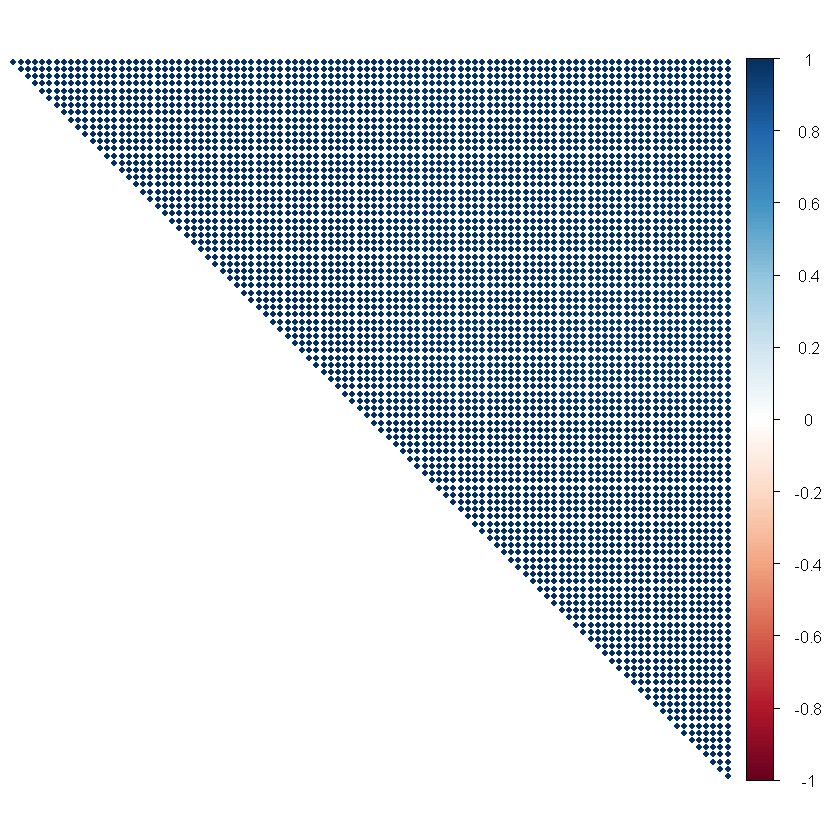

In [21]:
library(corrplot)
corrplot(cor(absorp),type="upper",order="hclust",addgrid.col = NA,tl.pos="n")

In [23]:
pca_obj <- prcomp(absorp,center=T,scale=T)
pca_var <- pca_obj$sdev^2/sum(pca_obj$sdev^2)*100
head(pca_var)

[1] 98.626192582  0.969705229  0.279324276  0.114429868  0.006460911
[6]  0.002624591

In [30]:
set.seed(1029)
absorp <- data.frame(absorp)
trn_id <- createDataPartition(endpoints[,3],p=3/4,list = F)
trnX <- absorp[trn_id,]
vldX <- absorp[-trn_id,]

trnY <- endpoints[trn_id,3]
vldY <- endpoints[-trn_id,3]

In [31]:
ctrl <- trainControl(method = "repeatedcv",repeats = 5)
set.seed(529)
fit_lm <- train(x=trnX,y=trnY,method = "lm",trControl = ctrl)
fit_lm

Linear Regression 

163 samples
100 predictors

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 147, 146, 147, 147, 147, 146, ... 
Resampling results:

  RMSE      Rsquared   MAE      
  1.350262  0.8811248  0.8021688

Tuning parameter 'intercept' was held constant at a value of TRUE

In [34]:
set.seed(529)
fit_pcr <- train(x=trnX,y=trnY,method = "pcr",trControl = ctrl,
                 tuneLength=25)
#fit_pcr$results

set.seed(529)
fit_pls<- train(x=trnX,y=trnY,method = "pls",trControl = ctrl,
                preProc=c("center","scale"),tuneLength=25)
#fit_pls$results

In [35]:
head(fit_pcr$results)

ncomp,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
1,2.901818,0.09868624,2.4968072,0.2560643,0.10926393,0.2042626
2,2.697017,0.21941841,2.2242314,0.2956034,0.12775431,0.2509888
3,2.246346,0.46319758,1.7798565,0.4167374,0.18596382,0.3244957
4,1.573498,0.72314546,1.1988172,0.4331457,0.14537455,0.2607383
5,1.410147,0.78526117,1.0938650,0.3317333,0.09701200,0.1974209
6,1.143021,0.86503029,0.9155592,0.2256198,0.04481956,0.1603696


In [37]:
cmpr <- rbind(fit_pcr$results,fit_pls$results)
cmpr$model <- rep(c("pcr","pls"),each=25)

In [38]:
head(cmpr)

ncomp,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD,model
1,2.901818,0.09868624,2.4968072,0.2560643,0.10926393,0.2042626,pcr
2,2.697017,0.21941841,2.2242314,0.2956034,0.12775431,0.2509888,pcr
3,2.246346,0.46319758,1.7798565,0.4167374,0.18596382,0.3244957,pcr
4,1.573498,0.72314546,1.1988172,0.4331457,0.14537455,0.2607383,pcr
5,1.410147,0.78526117,1.0938650,0.3317333,0.09701200,0.1974209,pcr
6,1.143021,0.86503029,0.9155592,0.2256198,0.04481956,0.1603696,pcr


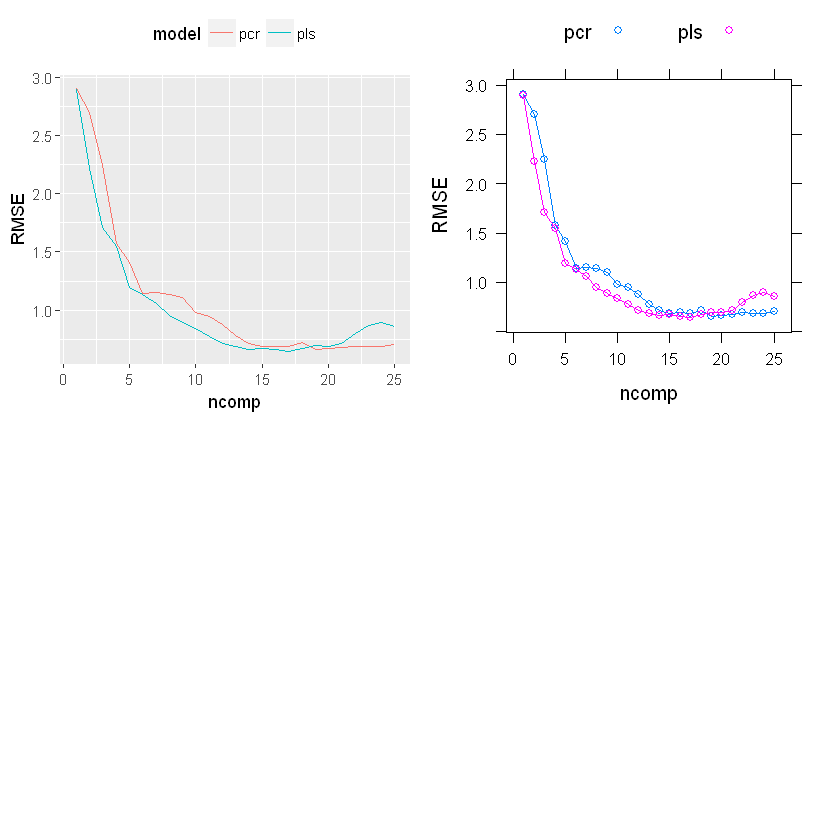

In [52]:
library(ggplot2)
p1 <- ggplot(aes(ncomp,RMSE,colour=model),data=cmpr) + geom_line() +theme(legend.position="top")

library(lattice)
p2 <- xyplot(RMSE~ncomp,data=cmpr,groups=model,type = 'o',auto.key = list(columns = 2))

library(gridExtra)
grid.arrange(p1, p2, ncol=2,nrow=2)   

In [65]:
#set.seed(529)
enet_grid <- expand.grid(lambda = c(0, .001, .01, .1, 1),
                         fraction = seq(0.05, 1, length = 20))

fit_enet<- train(x=trnX,y=trnY,method = "enet",trControl = ctrl,
                preProc=c("center","scale"),
                tuneGrid=enet_grid)

In [66]:
fit_enet$bestTune

fraction,lambda
0.05,0


6.2. Developing a model to predict permeability (see Sect. 1.4) could save significant resources for a pharmaceutical company, while at the same time more rapidly identifying molecules that have a sufficient permeability to become a drug:
- (a) Start R and use these commands to load the data:
```r
> library(AppliedPredictiveModeling)
> data(permeability)
```
The matrix fingerprints contains the 1,107 binary molecular predictors for the 165 compounds, while permeability contains permeability response.
- (b) The fingerprint predictors indicate the presence or absence of substructures of a molecule and are often sparse meaning that relatively few of the molecules contain each substructure. Filter out the predictors that have low frequencies using the nearZeroVar function from the caret package. How many predictors are left for modeling?
- (c) Split the data into a training and a test set, pre-process the data, and tune a PLS model. How many latent variables are optimal and what is the corresponding resampled estimate of R2?
- (d) Predict the response for the test set. What is the test set estimate of R2?
- (e) Try building other models discussed in this chapter. Do any have better predictive performance?
- (f) Would you recommend any of your models to replace the permeability laboratory experiment?

In [12]:
library(AppliedPredictiveModeling)
data(permeability)

In [13]:
dim(permeability)
dim(fingerprints)
any(is.na(permeability))
any(is.na(fingerprints))

[1] 165   1

[1]  165 1107

[1] FALSE

[1] FALSE

In [14]:
library(e1071)
skew_info <- apply(fingerprints,2,skewness)
head(order(skew_info,decreasing = T))
skewness(permeability)

[1] 110 114 148 273 415 416

[1] 1.396559

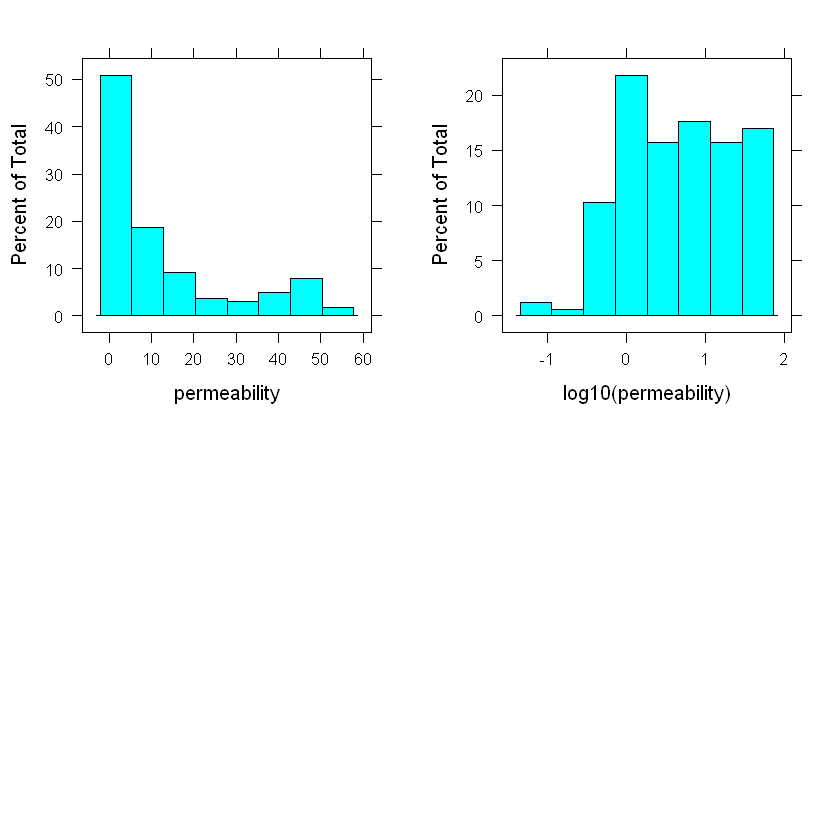

In [16]:
library(lattice)
p1 <- histogram(~permeability)
p2 <- histogram(~log10(permeability))
library(gridExtra)
grid.arrange(p1,p2,ncol=2,nrow=2)

In [18]:
library(caret)
nzv_info <- nearZeroVar(fingerprints,saveMetrics = T)
head(nzv_info)

,freqRatio,percentUnique,zeroVar,nzv
X1,3.342105,1.212121,FALSE,FALSE
X2,3.459459,1.212121,FALSE,FALSE
X3,3.714286,1.212121,FALSE,FALSE
X4,3.714286,1.212121,FALSE,FALSE
X5,3.714286,1.212121,FALSE,FALSE
X6,1.229730,1.212121,FALSE,FALSE


In [22]:
#flt_nzv <- nearZeroVar(fingerprints)
#fingerprints_flt_nzv <- fingerprints[,-flt_nzv]
fingerprints_flt_nzv <- fingerprints[,!nzv_info$nzv]

In [25]:
set.seed(614)
trn_id <- createDataPartition(permeability,p = 0.75,list = F)
trn_X <- fingerprints_flt_nzv[trn_id,]
trn_Y <- permeability[trn_id,]

vld_X <- fingerprints_flt_nzv[-trn_id,]
vld_Y <- permeability[-trn_id,]

In [33]:
set.seed(614)
ctrl <- trainControl(method = "LGOCV")
fit_pls <- train(x=trn_X,y=log10(trn_Y),method = "pls",tuneLength=15
                 ,trControl=ctrl,tuneGrid=expand.grid(ncomp=1:15))

ncomp,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
1,0.5660188,0.2381787,0.4699709,0.04800870,0.11800416,0.04579551
2,0.4978015,0.4146838,0.3915562,0.05065024,0.12182698,0.04606211
3,0.4887220,0.4395668,0.3859108,0.05136132,0.11518753,0.03837719
4,0.4857285,0.4608621,0.3885393,0.04530099,0.08389853,0.03839131
5,0.4719407,0.4950087,0.3755892,0.04305396,0.07284551,0.03286986
6,0.4570306,0.5288720,0.3574614,0.04868858,0.08717546,0.03519495


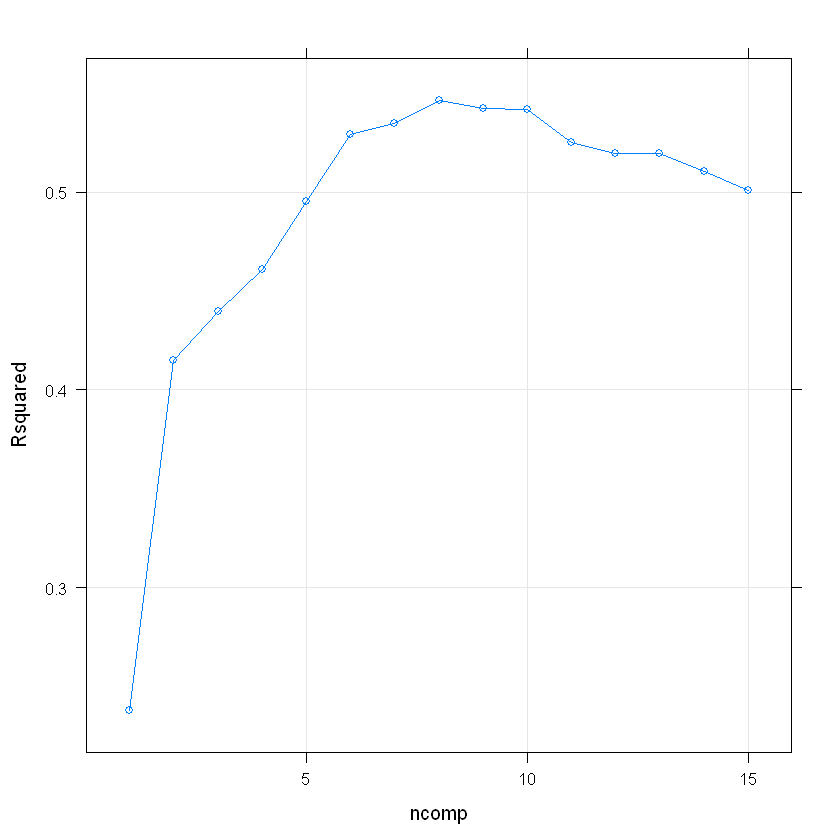

In [34]:
#fit_pls$bestTune
head(fit_pls$results)
library(lattice)
xyplot(Rsquared~ncomp,type=c("p","g","o"),data=fit_pls$results)